In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Python_code import examples as eg
import numpy as np
from numpy import *
from ripser import ripser

In [3]:
lamb= [0, .5, 1]
prime= 23
toll= 1e-5

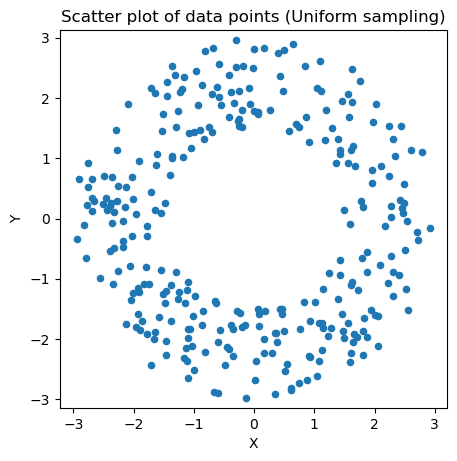

In [4]:
annulus = eg.annulus_example(R=1.5,d=1.5,n=300,Jacobian=False)
#annulus = np.loadtxt('Example1_d=0.5.txt')
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.
#plt.rcParams['lines.markersize'] = 150
#annulus=np.transpose(annulus)
plt.figure(figsize=(5,5), dpi=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', 'datalim')

scatter(annulus.T[0,:],annulus.T[1,:],s=20)
plt.axis('equal')
plt.title('Scatter plot of data points (Uniform sampling)')
plt.show()

# np.savetxt('Example1_d=7.5.txt',annulusJ)

data = annulus

In [5]:
import scipy as spy
def boundary_cocycles(rout, epsilon):
    # Construct 𝛿⁰
    distances = rout["dperm2all"]
    edges = array((distances<=epsilon).nonzero()).T

    I = c_[arange(edges.shape[0]),arange(edges.shape[0])]
    I = I.flatten()
    J = edges.flatten()
    V = c_[-1 * ones(edges.shape[0]), ones(edges.shape[0])]
    V = V.flatten()

    Delta = spy.sparse.coo_matrix((V,(I,J)), shape=(edges.shape[0], distances.shape[0]))
    # Extract the cocycles
    cocycles = []
    cocycles_val = []
    for cocycle in rout["cocycles"][1]:
        val = cocycle[:,2]
        val[val > (prime-1)/2] -= prime
        Y = spy.sparse.coo_matrix((val,(cocycle[:,0],cocycle[:,1])), shape=(distances.shape[0],distances.shape[0]))
        Y = Y - Y.T
        Z = zeros((Delta.shape[0],))
        Z = Y[edges[:,0],edges[:,1]]
        cocycles.append(Z)
        cocycles_val.append(val)
    return Delta,cocycles,cocycles_val

In [6]:
lp = 1
lq = 2
overall_coords = np.zeros(data.shape[0], dtype = float)
d = 1
lambda_parameter = 0
steps = 100

# the real figure

The exact solution is  x = 0                              
Before optim cost: 0.0
After  optim cost: nan  in  100  steps


<ipython-input-8-0eebab3e4215>:64: RuntimeWarning: invalid value encountered in remainder
  color = np.mod(res_tf.T[0,:]/res_tf.max(),1).T


Before optim cost: nan
After  optim cost: nan  in  100  steps
Before optim cost: 32683.69088257569
After  optim cost: 26094.30877045518  in  100  steps
Before optim cost: 90.23811438634758
After  optim cost: 88.8014895418085  in  100  steps
Before optim cost: 729545.055764137
After  optim cost: 677944.0220301594  in  100  steps
Before optim cost: 625.8489683759401
After  optim cost: 618.4630410692009  in  100  steps


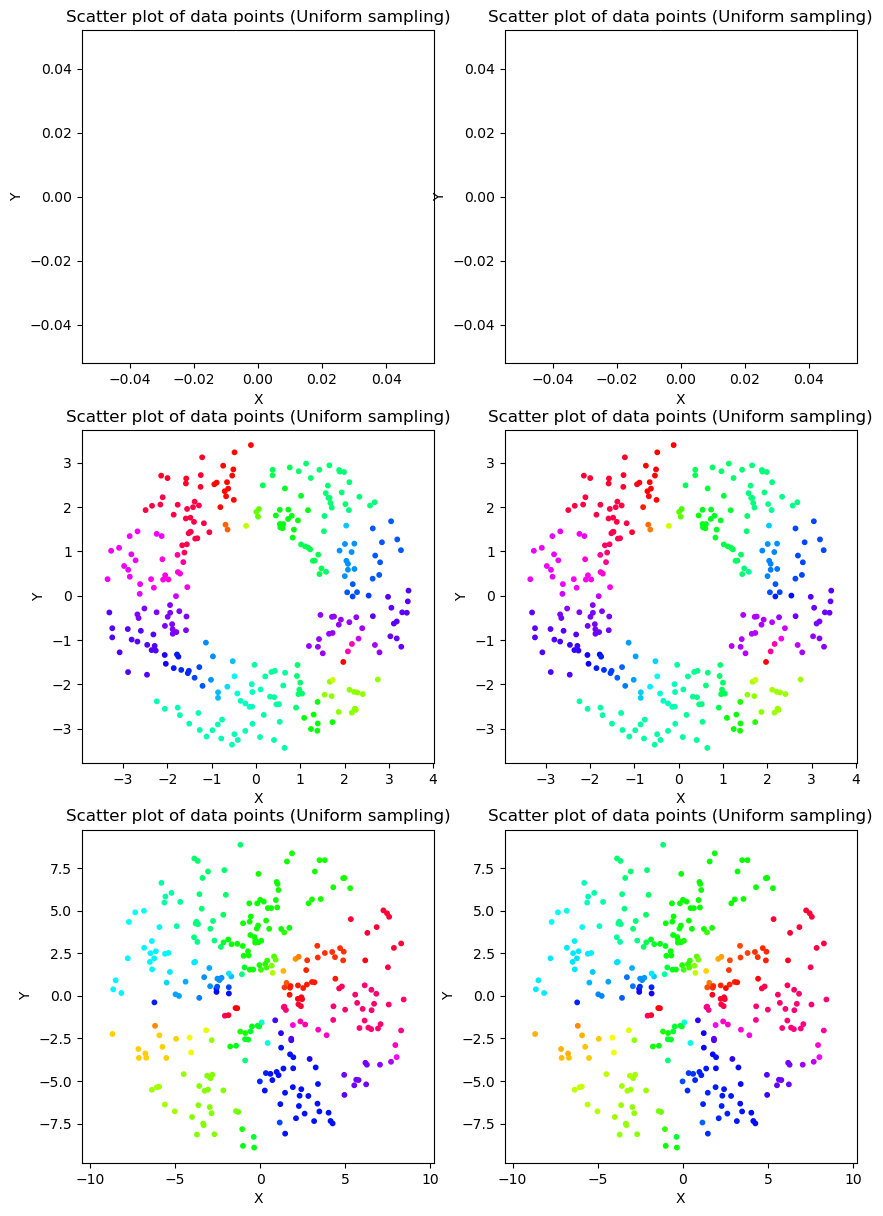

In [8]:
plot_n = 0
plt.figure(figsize=(10,15), dpi=100)

for d in [1,2,7.5]:
    # create the data set
    data = eg.annulus_example(R=1.5,d=d,n=300,Jacobian=False)
    
    # run PH and get cocycle
    diagrams = ripser(data, coeff=prime, do_cocycles=True)

    # choose distance threshold epsilon
    longest = np.diff(diagrams["dgms"][1]).argmax()
    chosen_cocycle = diagrams['cocycles'][1][longest]
    birth, death = diagrams["dgms"][1][longest]
    gig_comp = np.max(diagrams["dgms"][0][np.isfinite(diagrams["dgms"][0])]) # 
    if gig_comp < death:
        epsilon = max(birth, gig_comp)
    else:
        epsilon = birth

    # epsilon = min(birth+.1,birth+.5*(death-birth)) # if birth as epsilon gives problems try this
    # if gig_comp < death:
    #     epsilon = max(epsilon, gig_comp)
    # else:
    #     epsilon = epsilon

    # smooth cocycle and get boundary
    Delta, cocycles, cocycles_val = boundary_cocycles(diagrams, epsilon)
    from scipy.sparse.linalg import lsqr
    coord = lsqr(Delta, array(cocycles[longest]).squeeze() )
    l2_cocycle = coord[0]
    f = array(cocycles[longest]).squeeze()
    B_mat = Delta.todense()
    l2_cocycle = l2_cocycle.reshape(-1, 1)
    z_init = l2_cocycle
    ##It does not seem to work to have double invokes here...      
    import tensorflow as tf
    z = tf.Variable(z_init, name='z', trainable=True, dtype=tf.float64)
    trainable_variables = [z]
    
    # ---- run TF
    for lambda_parameter in [0,1]:
        def loss_function():
            cost_z = (1-lambda_parameter)*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.abs(f - tf.linalg.matmul(B_mat,z) ),lp ) ), 1/lp) + lambda_parameter*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.math.abs(f - tf.linalg.matmul(B_mat,z) ),lq ) ), 1/lq)
            return cost_z
        tf.random.set_seed(1)
        optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
        #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4) #Not recommended if you are not using tensorflow-gpu, may result a different result sometimes.
        B_mat = tf.Variable(B_mat, name="B_mat", trainable=False, dtype=tf.float64)
        f = tf.Variable(f, name="f", trainable=False, dtype=tf.float64)

        if int(steps)>0:
            print('Before optim cost:',loss_function().numpy())
            for i in range(int(steps)):
                train = optimizer.minimize(loss_function, var_list=trainable_variables)
                #err = np.sum(np.abs(z.numpy() - z_init))
                #print('>>> step',train.numpy(),' err=',err)
            print('After  optim cost:',loss_function().numpy(),' in ',train.numpy(),' steps')
            res_tf=z.numpy()
        else:
            print('Non-optimized cost:',loss_function().numpy())
            res_tf=z_init

        color = np.mod(res_tf.T[0,:]/res_tf.max(),1).T
        
        plot_n +=1
        # plot function
#         plt.figure(figsize=(10,5), dpi=100)
        plt.subplot(3,2,plot_n)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.gca().set_aspect('equal', 'datalim')
        scatter(data.T[0,:],data.T[1,:],
                c=color,cmap=cm.hsv,s=10,vmin=0,vmax=1)
        plt.title('Scatter plot of data points (Uniform sampling)')
        
plt.show()

The exact solution is  x = 0                              
Before optim cost: 0.0
After  optim cost: nan  in  100  steps


<ipython-input-9-34bde92721de>:64: RuntimeWarning: invalid value encountered in remainder
  color = np.mod(res_tf.T[0,:]/res_tf.max(),1).T


Before optim cost: nan
After  optim cost: nan  in  100  steps
Before optim cost: 155437.8069186508
After  optim cost: 119920.2161178362  in  100  steps
Before optim cost: 123.23591757166784
After  optim cost: 118.87979120999282  in  100  steps
Before optim cost: 507464.6562798192
After  optim cost: 472470.55130610237  in  100  steps
Before optim cost: 543.0797341369504
After  optim cost: 536.8843282689853  in  100  steps


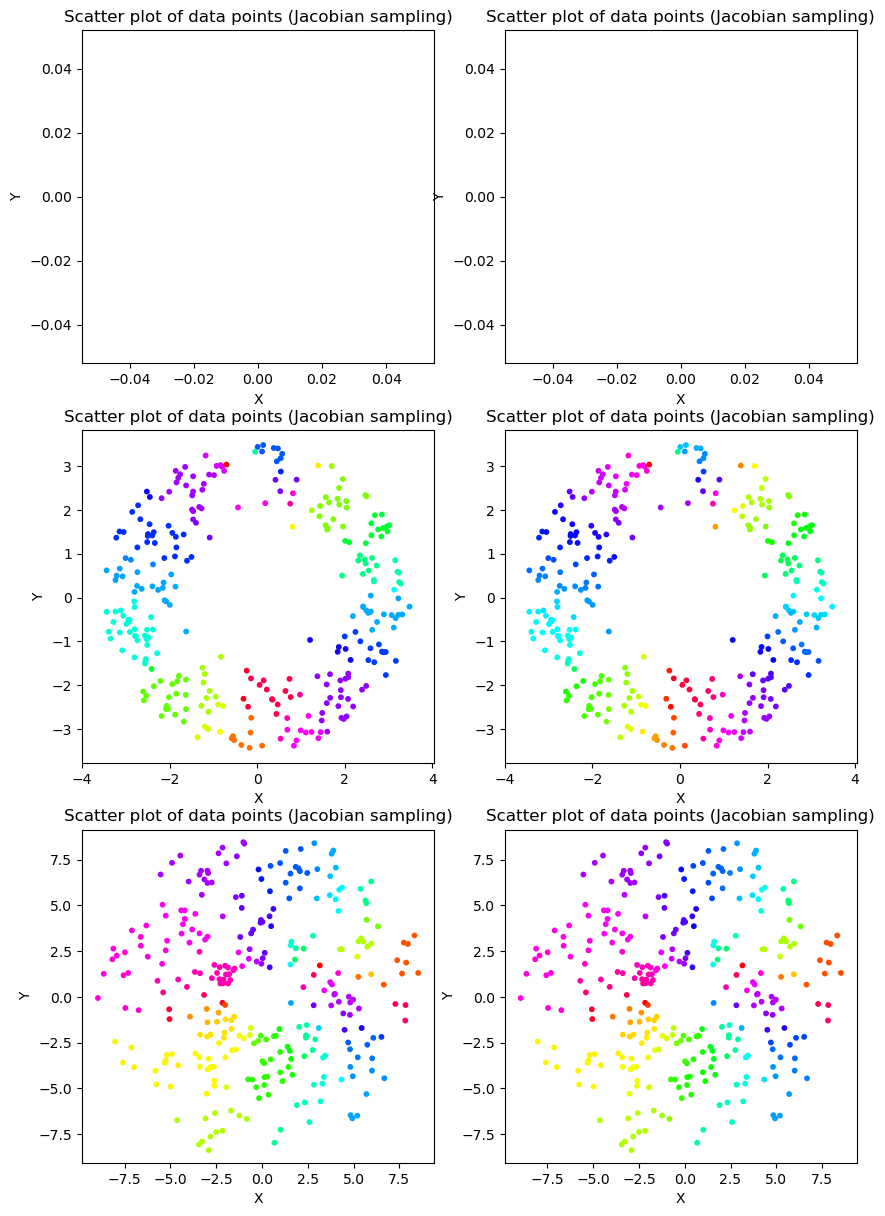

In [9]:
plot_n = 0
plt.figure(figsize=(10,15), dpi=100)

for d in [1,2,7.5]:
    # create the data set
    data = eg.annulus_example(R=1.5,d=d,n=300,Jacobian=True)
    
    # run PH and get cocycle
    diagrams = ripser(data, coeff=prime, do_cocycles=True)

    # choose distance threshold epsilon
    longest = np.diff(diagrams["dgms"][1]).argmax()
    chosen_cocycle = diagrams['cocycles'][1][longest]
    birth, death = diagrams["dgms"][1][longest]
    gig_comp = np.max(diagrams["dgms"][0][np.isfinite(diagrams["dgms"][0])]) # 
    if gig_comp < death:
        epsilon = max(birth, gig_comp)
    else:
        epsilon = birth

    # epsilon = min(birth+.1,birth+.5*(death-birth)) # if birth as epsilon gives problems try this
    # if gig_comp < death:
    #     epsilon = max(epsilon, gig_comp)
    # else:
    #     epsilon = epsilon

    # smooth cocycle and get boundary
    Delta, cocycles, cocycles_val = boundary_cocycles(diagrams, epsilon)
    from scipy.sparse.linalg import lsqr
    coord = lsqr(Delta, array(cocycles[longest]).squeeze() )
    l2_cocycle = coord[0]
    f = array(cocycles[longest]).squeeze()
    B_mat = Delta.todense()
    l2_cocycle = l2_cocycle.reshape(-1, 1)
    z_init = l2_cocycle
    ##It does not seem to work to have double invokes here...      
    import tensorflow as tf
    z = tf.Variable(z_init, name='z', trainable=True, dtype=tf.float64)
    trainable_variables = [z]
    
    # ---- run TF
    for lambda_parameter in [0,1]:
        def loss_function():
            cost_z = (1-lambda_parameter)*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.abs(f - tf.linalg.matmul(B_mat,z) ),lp ) ), 1/lp) + lambda_parameter*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.math.abs(f - tf.linalg.matmul(B_mat,z) ),lq ) ), 1/lq)
            return cost_z
        tf.random.set_seed(1)
        optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
        #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4) #Not recommended if you are not using tensorflow-gpu, may result a different result sometimes.
        B_mat = tf.Variable(B_mat, name="B_mat", trainable=False, dtype=tf.float64)
        f = tf.Variable(f, name="f", trainable=False, dtype=tf.float64)

        if int(steps)>0:
            print('Before optim cost:',loss_function().numpy())
            for i in range(int(steps)):
                train = optimizer.minimize(loss_function, var_list=trainable_variables)
                #err = np.sum(np.abs(z.numpy() - z_init))
                #print('>>> step',train.numpy(),' err=',err)
            print('After  optim cost:',loss_function().numpy(),' in ',train.numpy(),' steps')
            res_tf=z.numpy()
        else:
            print('Non-optimized cost:',loss_function().numpy())
            res_tf=z_init

        color = np.mod(res_tf.T[0,:]/res_tf.max(),1).T
        
        plot_n +=1
        # plot function
#         plt.figure(figsize=(10,5), dpi=100)
        plt.subplot(3,2,plot_n)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.gca().set_aspect('equal', 'datalim')
        scatter(data.T[0,:],data.T[1,:],
                c=color,cmap=cm.hsv,s=10,vmin=0,vmax=1)
        plt.title('Scatter plot of data points (Jacobian sampling)')
        
plt.show()